# Mod 4 Project - Starter Notebook

This notebook has been provided to you so that you can make use of the following starter code to help with the trickier parts of preprocessing the Zillow dataset. 

The notebook contains a rough outline the general order you'll likely want to take in this project. You'll notice that most of the areas are left blank. This is so that it's more obvious exactly when you should make use of the starter code provided for preprocessing. 

**_NOTE:_** The number of empty cells are not meant to infer how much or how little code should be involved in any given step--we've just provided a few for your convenience. Add, delete, and change things around in this notebook as needed!

# Some Notes Before Starting

This project will be one of the more challenging projects you complete in this program. This is because working with Time Series data is a bit different than working with regular datasets. In order to make this a bit less frustrating and help you understand what you need to do (and when you need to do it), we'll quickly review the dataset formats that you'll encounter in this project. 

## Wide Format vs Long Format

If you take a look at the format of the data in `zillow_data.csv`, you'll notice that the actual Time Series values are stored as separate columns. Here's a sample: 

<img src='https://raw.githubusercontent.com/learn-co-students/dsc-mod-4-project-seattle-ds-102819/master/images/df_head.png'>

You'll notice that the first seven columns look like any other dataset you're used to working with. However, column 8 refers to the median housing sales values for April 1996, column 9 for May 1996, and so on. This This is called **_Wide Format_**, and it makes the dataframe intuitive and easy to read. However, there are problems with this format when it comes to actually learning from the data, because the data only makes sense if you know the name of the column that the data can be found it. Since column names are metadata, our algorithms will miss out on what dates each value is for. This means that before we pass this data to our ARIMA model, we'll need to reshape our dataset to **_Long Format_**. Reshaped into long format, the dataframe above would now look like:

<img src='https://raw.githubusercontent.com/learn-co-students/dsc-mod-4-project-seattle-ds-102819/master/images/melted1.png'>

There are now many more rows in this dataset--one for each unique time and zipcode combination in the data! Once our dataset is in this format, we'll be able to train an ARIMA model on it. The method used to convert from Wide to Long is `pd.melt()`, and it is common to refer to our dataset as 'melted' after the transition to denote that it is in long format. 

# Helper Functions Provided

Melting a dataset can be tricky if you've never done it before, so you'll see that we have provided a sample function, `melt_data()`, to help you with this step below. Also provided is:

* `get_datetimes()`, a function to deal with converting the column values for datetimes as a pandas series of datetime objects
* Some good parameters for matplotlib to help make your visualizations more readable. 

Good luck!

## Auto Arima

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

from statsmodels.tsa.stattools import acf, pacf, adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import explained_variance_score

import pmdarima as pm
from pmdarima import model_selection
from pmdarima.utils import decomposed_plot
from pmdarima.arima import decompose, auto_arima
from pmdarima.arima.stationarity import ADFTest

from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly


C:\Users\coope\anaconda3\envs\time\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


In [2]:
df = pd.read_csv('Data/zillow_data.csv')
df

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14718,58333,1338,Ashfield,MA,Greenfield Town,Franklin,14719,94600.0,94300.0,94000.0,...,216800,217700,218600,218500,218100,216400,213100,209800,209200,209300
14719,59107,3293,Woodstock,NH,Claremont,Grafton,14720,92700.0,92500.0,92400.0,...,202100,208400,212200,215200,214300,213100,213700,218300,222700,225800
14720,75672,40404,Berea,KY,Richmond,Madison,14721,57100.0,57300.0,57500.0,...,121800,122800,124600,126700,128800,130600,131700,132500,133000,133400
14721,93733,81225,Mount Crested Butte,CO,NaN,Gunnison,14722,191100.0,192400.0,193700.0,...,662800,671200,682400,695600,695500,694700,706400,705300,681500,664400


In [3]:
df2 = pd.read_csv('Data/Zip_zhvi_uc_sfrcondo_tier_0.33_0.67_sm_sa_month.csv')
df2

,RegionID,SizeRank,RegionName,RegionType,StateName,State,City,Metro,CountyName,2000-01-31,...,2021-09-30,2021-10-31,2021-11-30,2021-12-31,2022-01-31,2022-02-28,2022-03-31,2022-04-30,2022-05-31,2022-06-30
0,61639,0,10025,Zip,NY,NY,New York,New York-Newark-Jersey City,New York County,324383.0,...,1132221.0,1136610.0,1135991.0,1136561.0,1142452.0,1154203.0,1172911.0,1189572.0,1203675.0,1209322.0
1,84654,1,60657,Zip,IL,IL,Chicago,Chicago-Naperville-Elgin,Cook County,313500.0,...,524133.0,526722.0,529521.0,531520.0,532909.0,533123.0,535804.0,537898.0,542946.0,546766.0
2,61637,2,10023,Zip,NY,NY,New York,New York-Newark-Jersey City,New York County,506994.0,...,1498926.0,1507590.0,1511855.0,1512170.0,1522793.0,1532550.0,1549563.0,1562744.0,1581340.0,1590483.0
3,91982,3,77494,Zip,TX,TX,Katy,Houston-The Woodlands-Sugar Land,Harris County,224938.0,...,421500.0,429474.0,436571.0,442317.0,448423.0,457973.0,469673.0,483460.0,494924.0,502464.0
4,84616,4,60614,Zip,IL,IL,Chicago,Chicago-Naperville-Elgin,Cook County,409547.0,...,668926.0,672856.0,677523.0,680459.0,682380.0,682141.0,685249.0,687700.0,693521.0,698444.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27361,59376,34430,4109,Zip,ME,ME,Portland,Portland-South Portland,Cumberland County,NaN,...,806919.0,813128.0,822283.0,840495.0,858963.0,876835.0,889859.0,898953.0,910047.0,919821.0
27362,66881,34430,21405,Zip,MD,MD,Annapolis,Baltimore-Columbia-Towson,Anne Arundel County,485917.0,...,1183236.0,1191227.0,1206366.0,1221326.0,1253345.0,1280884.0,1304040.0,1315300.0,1331683.0,1346265.0
27363,61694,34430,10118,Zip,NY,NY,New York,New York-Newark-Jersey City,New York County,NaN,...,2424820.0,2460697.0,2497199.0,2498360.0,2487681.0,2469249.0,2478155.0,2499420.0,2548896.0,2629722.0
27364,95186,34430,86343,Zip,AZ,AZ,Crown King,Prescott,Yavapai County,124025.0,...,213209.0,215313.0,214680.0,215007.0,216014.0,218662.0,229218.0,239730.0,249718.0,254153.0


In [4]:
df2 = df2.drop(columns = ['RegionType', 'StateName'])

In [5]:
state1 = df.loc[df['State'] == 'AL']

In [6]:
state1['RegionName'].unique()

array([35242, 36117, 36695, 36830, 35758, 35405, 35215, 36116, 35401,
       35216, 36608, 36301, 35630, 35226, 36526, 35244, 36532, 35209,
       36303, 36832, 36535, 35810, 35806, 35803, 35811, 35205, 35611,
       36609, 35173, 36109, 35801, 35007, 35124, 35805, 35023, 35243,
       36582, 36801, 35749, 35404, 35010, 35022, 35674, 36092, 35126,
       35633, 36066, 35235, 36606, 35613, 36693, 35901, 36575, 35214,
       35903, 35661, 36507, 36804, 35071, 35040, 35763, 35816, 35473,
       36870, 36305, 36618, 36571, 35406, 35080, 36106, 35121, 35475,
       35094, 35213, 35111, 36054, 35210, 35757, 36527, 36078, 36619,
       35045, 35115, 36567, 35120, 36541, 35180, 36111, 35954, 36877,
       36022, 35773, 35453, 36853, 35004, 35960, 36613, 35223, 35906,
       35660, 35634, 36064, 35043, 36604, 36544, 36093, 35146, 35824,
       36587, 35128, 35222, 35476, 35179, 35068, 35127, 36874, 35620,
       35085, 36551, 35079, 35907, 35051, 35759, 35031, 35005, 35614,
       35952, 35953,

In [7]:
zip1 = df.loc[df['RegionName'] == 36830]

In [8]:
def melt_data(df):
    """
    Takes the zillow_data dataset in wide form or a subset of the zillow_dataset.  
    Returns a long-form datetime dataframe 
    with the datetime column names as the index and the values as the 'values' column.
    
    If more than one row is passes in the wide-form dataset, the values column
    will be the mean of the values from the datetime columns in all of the rows.
    """
    
    melted = pd.melt(df, id_vars=['RegionName', 'RegionID', 'SizeRank', 'City', 'State', 'Metro', 'CountyName'], var_name='time')
    melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
    melted = melted.dropna(subset=['value'])
    return melted.groupby('time').aggregate({'value':'mean'})

In [9]:
melted_df = melt_data(zip1)
melted_df.head()

,value
time,
1996-04-01,123400.0
1996-05-01,123400.0
1996-06-01,123300.0
1996-07-01,123300.0
1996-08-01,123300.0


In [10]:
def get_datetimes(df):
    """
    Takes a dataframe:
    returns only those column names that can be converted into datetime objects 
    as datetime objects.
    NOTE number of returned columns may not match total number of columns in passed dataframe
    """
    
    return pd.to_datetime(df.columns.values[1:], format='%Y-%m')

In [11]:
melted_df.index = pd.to_datetime(melted_df.index)
melted_df.index

DatetimeIndex(['1996-04-01', '1996-05-01', '1996-06-01', '1996-07-01',
               '1996-08-01', '1996-09-01', '1996-10-01', '1996-11-01',
               '1996-12-01', '1997-01-01',
               ...
               '2017-07-01', '2017-08-01', '2017-09-01', '2017-10-01',
               '2017-11-01', '2017-12-01', '2018-01-01', '2018-02-01',
               '2018-03-01', '2018-04-01'],
              dtype='datetime64[ns]', name='time', length=265, freq=None)

In [12]:
font = {'family' : 'DejaVu Sans',
        'weight' : 'bold',
        'size'   : 12}

matplotlib.rc('font', **font)

# NOTE: if you visualizations are too cluttered to read, try calling 'plt.gcf().autofmt_xdate()'!

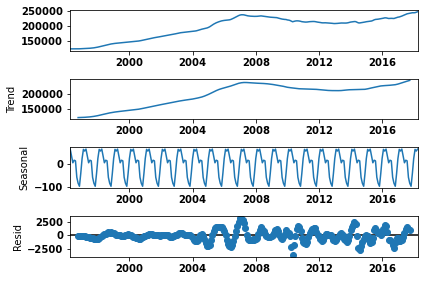

In [13]:
decomp = seasonal_decompose(melted_df)
decomp.plot();

In [14]:
train, test = train_test_split(melted_df, test_size = 60, shuffle=False)

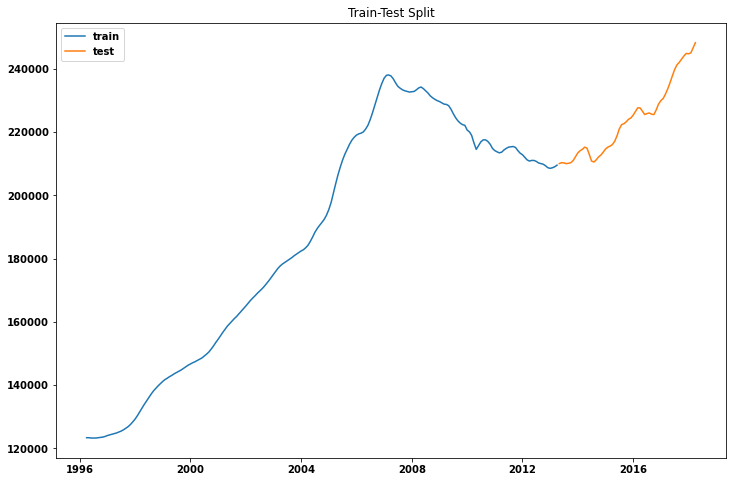

In [15]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(train, label='train')
ax.plot(test, label='test')
ax.set_title('Train-Test Split');
plt.legend();

In [16]:
arima_order = (1, 1, 1)

In [17]:
result = ARIMA(train, order=arima_order).fit()

C:\Users\coope\anaconda3\envs\time\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\coope\anaconda3\envs\time\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\coope\anaconda3\envs\time\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [18]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  value   No. Observations:                  205
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -1651.909
Date:                Thu, 11 Aug 2022   AIC                           3309.818
Time:                        09:54:43   BIC                           3319.773
Sample:                    04-01-1996   HQIC                          3313.845
                         - 04-01-2013                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9849      0.005    208.307      0.000       0.976       0.994
ma.L1         -0.9677      0.007   -135.849      0.000      -0.982      -0.954
sigma2      5.805e+05   2.78e-10   2.09e+15      0.000    5.81e+05    5.81e+05
===================================================================================
Ljung-Box (L1) (Q):                 161.07   Jarque-Bera (JB):                 5.81
Prob(Q):                              0.00   Prob(JB):                         0.05
Heteroskedasticity (H):               2.73   Skew:                             0.16
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.76
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.91e+30. Standard errors may be unstable.
"""

In [19]:
test_preds = result.forecast(steps=len(test))

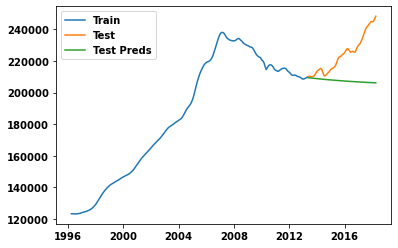

In [20]:
plt.plot(train, label = 'Train')
plt.plot(test, label = 'Test')
plt.plot(test_preds, label = 'Test Preds')
plt.legend();

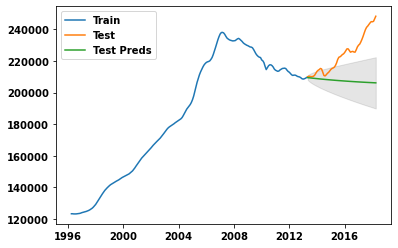

In [21]:
fcast = result.get_forecast(steps=len(test)).summary_frame()
fig, ax = plt.subplots()

ax.plot(train, label = 'Train')
ax.plot(test, label = 'Test')
ax.plot(fcast['mean'], label = 'Test Preds')
ax.fill_between(fcast.index, fcast['mean_ci_lower'], fcast['mean_ci_upper'], color='k', alpha=0.1);
ax.legend();

In [22]:
train, test = model_selection.train_test_split(melted_df, test_size=36)

In [23]:
adf_test = ADFTest(alpha=0.05)
p_val, diff = adf_test.should_diff(melted_df)
print(f"P-Value: {p_val}")
print(f"Difference: {diff}")

P-Value: 0.6844442584828669
Difference: True


In [24]:
arima = auto_arima(train,
    start_p=1,
    d=None,
    start_1=1,
    trace=True,
    m=12,
    seasonal=True) 

Performing stepwise search to minimize aic
 ARIMA(1,2,2)(1,0,1)[12]             : AIC=3377.081, Time=1.19 sec
 ARIMA(0,2,0)(0,0,0)[12]             : AIC=3376.051, Time=0.02 sec
 ARIMA(1,2,0)(1,0,0)[12]             : AIC=3376.882, Time=0.24 sec
 ARIMA(0,2,1)(0,0,1)[12]             : AIC=3377.181, Time=0.09 sec
 ARIMA(0,2,0)(1,0,0)[12]             : AIC=3378.167, Time=0.06 sec
 ARIMA(0,2,0)(0,0,1)[12]             : AIC=3377.902, Time=0.17 sec
 ARIMA(0,2,0)(1,0,1)[12]             : AIC=inf, Time=1.16 sec
 ARIMA(1,2,0)(0,0,0)[12]             : AIC=3375.028, Time=0.10 sec
 ARIMA(1,2,0)(0,0,1)[12]             : AIC=3377.051, Time=0.09 sec
 ARIMA(1,2,0)(1,0,1)[12]             : AIC=3378.100, Time=0.38 sec
 ARIMA(2,2,0)(0,0,0)[12]             : AIC=3375.152, Time=0.11 sec
 ARIMA(1,2,1)(0,0,0)[12]             : AIC=3376.004, Time=0.19 sec
 ARIMA(0,2,1)(0,0,0)[12]             : AIC=3375.363, Time=0.05 sec
 ARIMA(2,2,1)(0,0,0)[12]             : AIC=3374.571, Time=0.21 sec
 ARIMA(2,2,1)(1,0,0)[12]

In [25]:
arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  229
Model:               SARIMAX(1, 2, 2)   Log Likelihood               -1683.049
Date:                Thu, 11 Aug 2022   AIC                           3374.099
Time:                        09:54:54   BIC                           3387.798
Sample:                             0   HQIC                          3379.627
                                - 229                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8181      0.218      3.745      0.000       0.390       1.246
ma.L1         -0.7770      0.223     -3.485      0.000      -1.214      -0.340
ma.L2         -0.0761      0.021     -3.547      0.000      -0.118      -0.034
sigma2      1.469e+05   5166.094     28.437      0.000    1.37e+05    1.57e+05
===================================================================================
Ljung-Box (L1) (Q):                  12.04   Jarque-Bera (JB):              3163.29
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):              18.35   Skew:                             1.81
Prob(H) (two-sided):                  0.00   Kurtosis:                        20.92
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [26]:
test_preds = pd.Series(arima.predict(n_periods=len(test)), index=test.index)

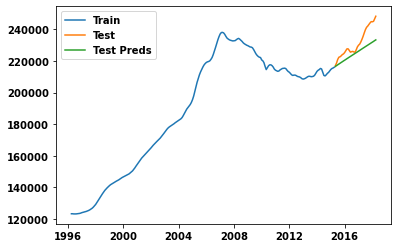

In [27]:
plt.plot(train, label = 'Train')
plt.plot(test, label = 'Test')
plt.plot(test_preds, label = 'Test Preds')
plt.legend();

In [28]:
seas_arima = ARIMA(train,
                   order=(1, 2, 2),
                   seasonal_order=(0, 0, 0, 12))
res_sarima = seas_arima.fit()
print(res_sarima.summary()) 

C:\Users\coope\anaconda3\envs\time\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\coope\anaconda3\envs\time\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\coope\anaconda3\envs\time\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                  229
Model:                 ARIMA(1, 2, 2)   Log Likelihood               -1683.049
Date:                Thu, 11 Aug 2022   AIC                           3374.099
Time:                        09:54:55   BIC                           3387.798
Sample:                    04-01-1996   HQIC                          3379.627
                         - 04-01-2015                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8181      0.218      3.745      0.000       0.390       1.246
ma.L1         -0.7770      0.223     -3.485      0.000      -1.214      -0.340
ma.L2         -0.0761      0.021     -3.547      0.0

In [64]:
def arima_model(zipcode, dataframe = df):
    '''
    This is an arima model predicting housing prices based on zipcode by taking in a zipcode
    and dataframe and outputting a prediction for the last 12 months, as well as the R-Sqaured,
    Mean Absolute Error, and Root Mean Squared Error scores.
    '''
    zipcode = dataframe.loc[dataframe['RegionName'] == zipcode]
    melted_df = melt_data(zipcode)
    melted_df.index = pd.to_datetime(melted_df.index)
    train, test = train_test_split(melted_df, test_size = 12, shuffle=False)
    arima = auto_arima(train,
        start_p=1,
        d=None,
        start_1=1,
        trace=True,
        m=12,
        seasonal=True)
    test_preds = pd.Series(arima.predict(n_periods=len(test)), index=test.index)
    print(f"R2 Score: {r2_score(test, test_preds):.4f}")
    print(f"MAE Score: ${mean_absolute_error(test, test_preds):.4f}")
    print(f"RMSE Score: ${mean_squared_error(test, test_preds, squared=False):.4f}")
    actual = train['value'].values[-1]
    trend = test_preds.values[-1]
    ROI = trend - actual
    print(f"ROI: ${(ROI):.4f}")
    fig, ax = plt.subplots(figsize = (8, 6))
    ax.plot(train, label = 'Train')
    ax.plot(test, label = 'Test')
    ax.plot(test_preds, label = 'Test Preds')
    plt.xlabel('Year', fontsize=20)
    plt.ylabel('Median Housing Price', fontsize=20)
    ax.yaxis.set_major_formatter('${x:1.0f}')
    plt.legend()
    return test_preds

Performing stepwise search to minimize aic
 ARIMA(1,2,2)(1,0,1)[12]             : AIC=3757.016, Time=1.32 sec
 ARIMA(0,2,0)(0,0,0)[12]             : AIC=3752.603, Time=0.02 sec
 ARIMA(1,2,0)(1,0,0)[12]             : AIC=3754.439, Time=0.08 sec
 ARIMA(0,2,1)(0,0,1)[12]             : AIC=3754.567, Time=0.12 sec
 ARIMA(0,2,0)(1,0,0)[12]             : AIC=3752.418, Time=0.11 sec
 ARIMA(0,2,0)(2,0,0)[12]             : AIC=3752.957, Time=0.16 sec
 ARIMA(0,2,0)(1,0,1)[12]             : AIC=3753.384, Time=0.52 sec
 ARIMA(0,2,0)(0,0,1)[12]             : AIC=3753.509, Time=0.20 sec
 ARIMA(0,2,0)(2,0,1)[12]             : AIC=3754.977, Time=1.32 sec
 ARIMA(0,2,1)(1,0,0)[12]             : AIC=3754.505, Time=0.41 sec
 ARIMA(1,2,1)(1,0,0)[12]             : AIC=3761.355, Time=0.12 sec
 ARIMA(0,2,0)(1,0,0)[12] intercept   : AIC=3754.317, Time=0.58 sec

Best model:  ARIMA(0,2,0)(1,0,0)[12]          
Total fit time: 4.988 seconds
R2 Score: 0.8670
MAE Score: $5464.6633
RMSE Score: $5794.9132
ROI: $48800.4

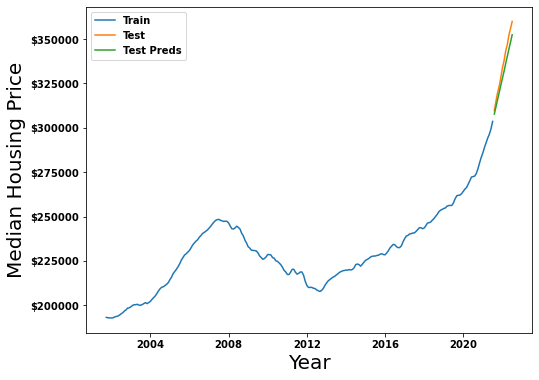

In [65]:
test_preds = arima_model(35173, df2)

In [60]:
test_preds

(time
 2021-07-31    307693.853922
 2021-08-31    311778.813525
 2021-09-30    315844.364955
 2021-10-31    319896.388905
 2021-11-30    323955.665087
 2021-12-31    328022.287442
 2022-01-31    332078.801764
 2022-02-28    336149.238116
 2022-03-31    340213.061034
 2022-04-30    344288.870801
 2022-05-31    348346.268166
 2022-06-30    352384.426451
 dtype: float64,)

## Facebook Prophet

In [ ]:
zipcode = df.loc[df['RegionName'] == 35173]
melted_df = melt_data(zipcode)
melted_df['ds'] = pd.to_datetime(melted_df.index)

In [ ]:
m_df = melted_df.reset_index(drop=True)
m_df.head()

In [ ]:
m_df = m_df.rename(columns={'value': 'y'})

In [ ]:
m_df = m_df[['ds', 'y']]

In [ ]:
m_df

In [ ]:
model = Prophet()
model.fit(m_df)

In [ ]:
future = model.make_future_dataframe(periods=len(test), freq='MS')
forecast = model.predict(future)
forecast

In [ ]:
future

In [ ]:
fig1 = model.plot(forecast)

In [ ]:
fig2 = model.plot_components(forecast)

In [ ]:
test.index

In [ ]:
forecast_test = forecast.loc[forecast['ds'].isin(test.index), 'yhat']
forecast_test

In [ ]:
len(test)

In [ ]:
forecast.loc[(forecast['ds'] >= test.index[0]) & (forecast['ds'] <= test.index[-1])]

In [ ]:
print(f"R2 Score: {r2_score(test, forecast_test):.4f}")
print(f"MAE Score: ${mean_absolute_error(test, forecast_test):.4f}")
print(f"RMSE Score: ${mean_squared_error(test, forecast_test, squared=False):.4f}")

In [ ]:
type(forecast['ds'][0]) #>= test.index[0]

In [ ]:
type(test.index[0])

In [ ]:
def prophet_model(zipcode, dataframe = df):
    '''
    This is an facebook prophet model predicting housing prices based on zipcode by taking in a zipcode
    and dataframe and outputting a prediction for the last 12 months.
    '''
    zipcode = dataframe.loc[dataframe['RegionName'] == zipcode]
    melted_df = melt_data(zipcode)
    melted_df['ds'] = pd.to_datetime(melted_df.index)
    m_df = melted_df.reset_index(drop=True)
    m_df = m_df.rename(columns={'value': 'y'})
    m_df = m_df[['ds', 'y']]
    train, test = train_test_split(m_df, test_size = 12, shuffle=False, random_state = 42)
    model = Prophet()
    model.fit(train)
    future = model.make_future_dataframe(periods=len(test), freq = 'M')
    forecast = model.predict(future)
    forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
    forecast_test = forecast.loc[forecast['ds'].isin(test['ds']), 'yhat']
    print(f"Explained Variance Score: {explained_variance_score(test['y'], forecast_test):.4f}")
    print(f"MbAE Score: ${mean_absolute_error(test['y'], forecast_test):.4f}")
    print(f"RMSE Score: ${mean_squared_error(test['y'], forecast_test, squared=False):.4f}")
    actual = forecast['yhat'].loc[forecast['yhat'].index[-13]]
    trend = forecast['trend'].loc[forecast['trend'].index[-1]]
    print(f"ROI: ${(trend - actual):.4f}")
    fig1 = model.plot(forecast)
    fig2 = model.plot_components(forecast)
    return forecast

In [ ]:
a = prophet_model(35173, df2)

In [ ]:
zipcode = df2.loc[df2['RegionName'] == 35120]
melted_df = melt_data(zipcode)
melted_df['ds'] = pd.to_datetime(melted_df.index)
m_df = melted_df.reset_index(drop=True)
m_df = m_df.rename(columns={'value': 'y'})
m_df = m_df[['ds', 'y']]
train, test = train_test_split(m_df, test_size = 12, shuffle=False, random_state = 42)
model = Prophet()
model.fit(train)
future = model.make_future_dataframe(periods=len(test), freq = 'M')
forecast = model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]


In [ ]:
test

In [ ]:
forecast.tail()

In [ ]:
forecast_test = forecast.loc[forecast['ds'].isin(test['ds']), 'yhat']

In [ ]:
forecast_test

In [ ]:
print(f"R2 Score: {r2_score(test['y'], forecast_test):.4f}")
print(f"MAE Score: ${mean_absolute_error(test['y'], forecast_test):.4f}")
print(f"RMSE Score: ${mean_squared_error(test['y'], forecast_test, squared=False):.4f}")

In [ ]:
residuals = test['y'] - forecast_test

In [ ]:
forecast['yhat']

In [ ]:
forecast['trend']

In [ ]:
forecast['trend'].loc[forecast['trend'].index[-1]]

In [ ]:
forecast['yhat'].loc[forecast['yhat'].index[-13]]

## Best Zipcodes by State

In [67]:
state1 = df2.loc[df2['State'] == 'AL']
state1

,RegionID,SizeRank,RegionName,State,City,Metro,CountyName,2000-01-31,2000-02-29,2000-03-31,...,2021-09-30,2021-10-31,2021-11-30,2021-12-31,2022-01-31,2022-02-28,2022-03-31,2022-04-30,2022-05-31,2022-06-30
320,73409,322,35242,AL,Hoover,Birmingham-Hoover,Jefferson County,NaN,NaN,NaN,...,447087.0,453119.0,459200.0,466566.0,472932.0,478645.0,483603.0,491109.0,498362.0,506510.0
442,73761,445,36117,AL,Montgomery,Montgomery,Montgomery County,156678.0,156865.0,156927.0,...,207044.0,210073.0,212916.0,215823.0,219111.0,222879.0,226674.0,230413.0,233644.0,236248.0
717,74003,720,36695,AL,Mobile,Mobile,Mobile County,137173.0,137555.0,137762.0,...,234571.0,238275.0,241500.0,244941.0,247818.0,251083.0,254788.0,258386.0,260711.0,262335.0
763,74056,765,36830,AL,Auburn,Auburn-Opelika,Lee County,150973.0,151356.0,151483.0,...,300538.0,300570.0,299274.0,302544.0,311378.0,321138.0,326140.0,329044.0,334864.0,341006.0
794,73596,797,35758,AL,Madison,Huntsville,Madison County,NaN,NaN,NaN,...,321250.0,328422.0,334603.0,341034.0,347472.0,355227.0,361272.0,366661.0,370787.0,374835.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26019,74028,29056,36754,AL,Magnolia,NaN,Marengo County,NaN,NaN,NaN,...,77589.0,77933.0,78251.0,78739.0,78032.0,78441.0,78322.0,79474.0,79878.0,80881.0
26712,74049,30474,36790,AL,Stanton,Birmingham-Hoover,Chilton County,NaN,NaN,NaN,...,102994.0,103423.0,103044.0,103581.0,105063.0,107743.0,108852.0,109778.0,110482.0,112337.0
26797,73930,30646,36550,AL,Little River,Daphne-Fairhope-Foley,Baldwin County,NaN,NaN,NaN,...,175959.0,178912.0,180740.0,182712.0,183956.0,188783.0,190968.0,193521.0,194032.0,192565.0
26801,73590,30679,35751,AL,Hollytree,Scottsboro,Jackson County,NaN,NaN,NaN,...,122996.0,123710.0,125081.0,128053.0,132385.0,137071.0,139512.0,141328.0,142096.0,143203.0


In [80]:
state_zip = state1['RegionName'].unique()

In [84]:
zip_list = []
for zipcode in state_zip:
    zip_list.append(zipcode)
zip_list

[35242,
 36117,
 36695,
 36830,
 35758,
 35215,
 35405,
 36116,
 35401,
 35216,
 36608,
 36301,
 36330,
 35630,
 35226,
 36526,
 36532,
 35244,
 36535,
 35209,
 35601,
 35603,
 36832,
 36303,
 35810,
 35806,
 35211,
 36542,
 35803,
 36561,
 35811,
 35205,
 35611,
 35173,
 36605,
 36609,
 35802,
 35640,
 36109,
 35801,
 35160,
 36067,
 35007,
 35124,
 35020,
 35243,
 35805,
 35023,
 35749,
 36801,
 36582,
 36867,
 35404,
 35022,
 35010,
 36701,
 35055,
 35674,
 36265,
 35613,
 36869,
 36092,
 36360,
 36066,
 35126,
 35950,
 36207,
 35633,
 36203,
 35150,
 35235,
 36606,
 35901,
 36693,
 36108,
 36575,
 35214,
 35661,
 35903,
 36507,
 35976,
 36804,
 35763,
 35016,
 36081,
 36201,
 35040,
 35756,
 35071,
 36854,
 35816,
 35473,
 36870,
 36305,
 36571,
 35406,
 36618,
 35080,
 35957,
 35206,
 36027,
 36106,
 35213,
 35967,
 35475,
 35210,
 35111,
 35121,
 36502,
 35757,
 36527,
 36426,
 35094,
 36054,
 35208,
 36619,
 35650,
 35045,
 36078,
 35120,
 36567,
 35115,
 36037,
 35904,
 35077,


In [86]:
def RBZ(zipcode):
    zipcode = df2.loc[df2['RegionName'] == zipcode]
    melted_df = melt_data(zipcode)
    melted_df.index = pd.to_datetime(melted_df.index)
    train, test = train_test_split(melted_df, test_size = 12, shuffle=False)
    arima = auto_arima(train,
        start_p=1,
        d=None,
        start_1=1,
        trace=True,
        m=12,
        seasonal=True)
    test_preds = pd.Series(arima.predict(n_periods=len(test)), index=test.index)
    actual = train['value'].values[-1]
    trend = test_preds.values[-1]
    ROI = trend - actual
    return ROI

In [90]:
def BREAK(state):
    state = df2.loc[df2['State'] == state]
    state_zip = state1['RegionName'].unique()
    zip_list = []
    for zipcode in state_zip:
        zip_list.append(zipcode)
        zipcode = df2.loc[df2['RegionName'] == zipcode]
        melted_df = melt_data(zipcode)
        melted_df.index = pd.to_datetime(melted_df.index)
        train, test = train_test_split(melted_df, test_size = 12, shuffle=False)
        arima = auto_arima(train,
            start_p=1,
            d=None,
            start_1=1,
            trace=False,
            m=12,
            seasonal=True)
        test_preds = pd.Series(arima.predict(n_periods=len(test)), index=test.index)
        actual = train['value'].values[-1]
        trend = test_preds.values[-1]
        ROI = trend - actual
        ROI_list = []
        ROI_list.append(ROI)
    RBZ = dict(zip(zip_list, ROI_list))
    sorted_RBZ = dict(sorted(RBZ.items(),key= lambda x:x[1]))
    top_zip = sorted_RBZ[-1]
    return top_zip

In [91]:
al_best_zip = BREAK('AL')

ValueError: All lag values up to 'maxlag' produced singular matrices. Consider using a longer series, a different lag term or a different test.